# Capture d'informations à partir des lettres majuscules avec l'embedding de caractères


Une autre amélioration potentielle consiste à appliquer l'embedding de caractères. Une représentation d'embeddings de mots pré-entraînée, telle que word2vec, peut nécessiter de transformer les mots en minuscules. Pourtant, comme le font les humains, les lettres majuscules contiennent des informations utiles pour déterminer si un mot est une entité nommée ou non. Par conséquent, dans ce notebook, nous incluons l'embedding au niveau des caractères avec le Convolutional Neural Network (CNN). 

In [1]:
#!pip install torchtext==0.6.0

import time
import torch
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain

## Préparer les données

Torchtext fournit une classe pratique pour gérer une entrée basée sur des caractères appelée `NestedField`. Pour inclure les caractères en tant que `NestedField`, nous devons créer une sorte de conteneur ` char_nesting_field`, puis spécifier cet objet comme paramètre pour le `NestedField`. 
Pour la tokenisation, on utilise la fonction intégrée `list` pour transformer le mot en caractères. La fonction de tokenisation peut être spécifiée dans le conteneur `Field`. 

On construit également le vocabulaire pour le `char_field`

In [2]:
# pour la reproductibilité
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
TEXT = data.Field(lower = True) 
TAG = data.Field(unk_token = None) # les tags sont tous connus on a alors unk_token = None
CHAR_NESTING= Field(tokenize=list)
CHAR = NestedField(CHAR_NESTING) 

In [4]:
my_path = "data_ner/"

train_data, valid_data, test_data = data.TabularDataset.splits(
        path= my_path,
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(
            (("text", "char"), (TEXT, CHAR)), 
            ("tag", TAG)
        )
    )

In [5]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 14986
Number of validation examples: 3465
Number of testing examples: 3683


In [6]:
MIN_FREQ = 0

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ, # les mots qui apparaissent moins que MIN_FREQ fois seront ignorés du vocabulaire
                 vectors = "glove.6B.300d",
                 unk_init = torch.Tensor.normal_)


TAG.build_vocab(train_data)
CHAR.build_vocab(train_data) 

# préparer les index de padding qui devront être ignorés pendant le training et l'évaluation
TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
CHAR_PAD_IDX = CHAR.vocab.stoi[CHAR.pad_token]  
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

In [7]:
print(f"Unique tokens dans le vocabulaire de TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens dans le vocabulaire de TAG : {len(TAG.vocab)}")
print(f"Unique tokens dans le vocabulaire de CHAR : {len(CHAR.vocab)}")

Unique tokens dans le vocabulaire de TEXT vocabulary: 21012
Unique tokens dans le vocabulaire de TAG : 10
Unique tokens dans le vocabulaire de CHAR : 86


On affiche un exemple : 

In [8]:
print(vars(train_data.examples[1]))

{'text': ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'], 'char': [['E', 'U'], ['r', 'e', 'j', 'e', 'c', 't', 's'], ['G', 'e', 'r', 'm', 'a', 'n'], ['c', 'a', 'l', 'l'], ['t', 'o'], ['b', 'o', 'y', 'c', 'o', 't', 't'], ['B', 'r', 'i', 't', 'i', 's', 'h'], ['l', 'a', 'm', 'b'], ['.']], 'tag': ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']}


In [34]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort=False)

# Construire le modèle

Il y a deux nouvelles couches a ajouter basé sur le modèle de [Ma & Hovy (2016)](https://arxiv.org/abs/1603.01354):

1. embedding de caractères
2. CNN de l'embedding de caractères

In [35]:
class BiLSTM(nn.Module):

    def __init__(self,
                 input_dim,
                 embedding_dim,
                 char_emb_dim,  
                 char_input_dim,  
                 char_cnn_filter_num,  
                 char_cnn_kernel_size, 
                 hidden_dim,
                 output_dim,
                 lstm_layers,
                 emb_dropout,
                 cnn_dropout,  
                 lstm_dropout,
                 fc_dropout,
                 word_pad_idx,
                 char_pad_idx):  
        super().__init__()
        
        # Couche 1A: Word Embedding
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=word_pad_idx
        )
        self.emb_dropout = nn.Dropout(emb_dropout) 
        
        # Couche 1B: Char Embedding-CNN
        self.char_emb_dim = char_emb_dim
        self.char_emb = nn.Embedding(
            num_embeddings=char_input_dim,
            embedding_dim=char_emb_dim,
            padding_idx=char_pad_idx
        )
        self.char_cnn = nn.Conv1d(
            in_channels=char_emb_dim,
            out_channels=char_emb_dim * char_cnn_filter_num,
            kernel_size=char_cnn_kernel_size,
            groups=char_emb_dim  # different 1d conv for each embedding dim
        )
        self.cnn_dropout = nn.Dropout(cnn_dropout)
        
        # Couche 2: BiLSTM
        self.lstm = nn.LSTM(
            input_size= embedding_dim + (char_emb_dim * char_cnn_filter_num),
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0
        )
        
        # Couche 3: Fully-connected
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # fois 2 car bidirectionnel
        
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, chars):
        
        # words = [sentence length, batch size]
        # chars = [batch size, sentence length, word length)
        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.emb_dropout(self.embedding(words))

        # char_emb_out = [batch size, sentence length, word length, char emb dim]
        char_emb_out = self.emb_dropout(self.char_emb(chars))
        batch_size, sent_len, word_len, char_emb_dim = char_emb_out.shape
        char_cnn_max_out = torch.zeros(batch_size, sent_len, self.char_cnn.out_channels)
        
        # pour l'embedding des caractères, on doit itérer sur les phrases       
        for sent_i in range(sent_len):
            # sent_char_emb = [batch size, word length, char emb dim]
            sent_char_emb = char_emb_out[:, sent_i, :, :]  # get the character field of sent i
            # sent_char_emb_p = [batch size, char emb dim, word length]
            sent_char_emb_p = sent_char_emb.permute(0, 2, 1)  # the channel (char emb dim) has to be the last dimension
            # char_cnn_sent_out = [batch size, out channels * char emb dim, word length - kernel size + 1]
            char_cnn_sent_out = self.char_cnn(sent_char_emb_p)
            char_cnn_max_out[:, sent_i, :], _ = torch.max(char_cnn_sent_out, dim=2)  # max pooling over the word length dimension
        char_cnn = self.cnn_dropout(char_cnn_max_out)

        # char_cnn_p = [sentence length, batch size, char emb dim * num filter]
        char_cnn_p = char_cnn.permute(1, 0, 2).to(device)
        word_features = torch.cat((embedding_out, char_cnn_p), dim=2)

        # lstm_out = [sentence length, batch size, hidden dim * 2]
        lstm_out, _ = self.lstm(word_features)
        # ner_out = [sentence length, batch size, output dim]
        ner_out = self.fc(self.fc_dropout(lstm_out))
        return ner_out

    def init_embeddings(self, char_pad_idx, word_pad_idx, pretrained=None, freeze=True):
        # initialise l'embedding pour les tokens pad à zéro
        self.embedding.weight.data[word_pad_idx] = torch.zeros(self.embedding_dim)
        self.char_emb.weight.data[char_pad_idx] = torch.zeros(self.char_emb_dim)
        if pretrained is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embeddings=torch.as_tensor(pretrained),
                padding_idx=word_pad_idx,
                freeze=freeze
            )

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [36]:
model = BiLSTM(
    input_dim=len(TEXT.vocab),
    embedding_dim=300,
    char_emb_dim=25,
    char_input_dim=len(CHAR.vocab),
    char_cnn_filter_num=5,
    char_cnn_kernel_size=3,
    hidden_dim=64,
    output_dim=len(TAG.vocab),
    lstm_layers=2,
    emb_dropout=0.5,
    cnn_dropout=0.25,
    lstm_dropout=0.1,
    fc_dropout=0.25,
    word_pad_idx=TEXT_PAD_IDX,
    char_pad_idx=CHAR_PAD_IDX
)
model.init_embeddings(
    char_pad_idx=CHAR_PAD_IDX,
    word_pad_idx=TEXT_PAD_IDX ,
    freeze=True
)
print(f"Le modèle a {model.count_parameters():,} paramètres à entraîner.")

Le modèle a 6,658,260 paramètres à entraîner.


# Entraînement

 - Optimiseur et fonction loss

In [37]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

model = model.to(device)
criterion = criterion.to(device)

 - Métriques

In [38]:
def accuracy_per_tag(predictions, tags):
    n_tags = len(TAG.vocab)
    class_correct = list(0 for i in range(n_tags))
    class_total = list(0 for i in range(n_tags))
    acc = list(0 for i in range(n_tags))
    _, pred = torch.max(predictions, 1)
    # # compare predictions to true label
    correct = np.squeeze(pred.eq(tags.data.view_as(pred)))
    # # calculate test accuracy for each object class
    for i in range(len(tags.data)):
        label = tags.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    for i in range(n_tags):
        if np.sum(class_total[i]) == 0 and np.sum(class_correct[i]) ==0:
            res = 100
        else:
            res = 100 * class_correct[i] / class_total[i]
        acc[i] = res, np.sum(class_correct[i]), np.sum(class_total[i])
        
    return acc  

from sklearn.metrics import f1_score
def f1_loss(preds, y, tag_pad_idx):

    positive_labels = [i for i in range(len(TAG.vocab.itos))
                           if i != tag_pad_idx]
    _, pred = torch.max(preds, 1)
    pred = pred.data.cpu().numpy() 
    tags = y.data.cpu().numpy()
    f1 = f1_score(
            y_true=tags,
            y_pred=pred,
            labels=positive_labels,
            average="micro"
        ) 
       
    return f1


In [39]:
def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0
    acc = []
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
        chars = batch.char 
        optimizer.zero_grad()
        
        #text = [sent len, batch size]
        
        predictions = model(text,chars)
        
        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]
        
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        #predictions = [sent len * batch size, output dim]
        #tags = [sent len * batch size]
        
        loss = criterion(predictions, tags)
                
        f1 = f1_loss(predictions, tags, tag_pad_idx)
        acc.append(accuracy_per_tag(predictions, tags))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator),  acc, epoch_f1 / len(iterator)

def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0
    acc = []
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
            chars = batch.char
            predictions = model(text,chars)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            acc.append(accuracy_per_tag(predictions, tags))
            f1 = f1_loss(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), acc, epoch_f1 / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 5
t_loss = []
t_f1 = []
v_loss = []
v_f1 = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_f1  = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    t_loss.append(train_loss)
    t_f1.append(train_f1)      
    
    valid_loss, valid_acc, valid_f1 = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    v_loss.append(valid_loss)
    v_f1.append(valid_f1)       
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
        
    if epoch%2 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 10m 36s
	Train Loss: 0.453 | Train F1 score: 43.24%
	 Val. Loss: 0.173 |  Val. F1 score: 54.17%
Epoch: 03 | Epoch Time: 13m 35s
	Train Loss: 0.054 | Train F1 score: 48.29%
	 Val. Loss: 0.078 |  Val. F1 score: 55.71%
Epoch: 05 | Epoch Time: 12m 10s
	Train Loss: 0.022 | Train F1 score: 48.76%
	 Val. Loss: 0.079 |  Val. F1 score: 55.78%


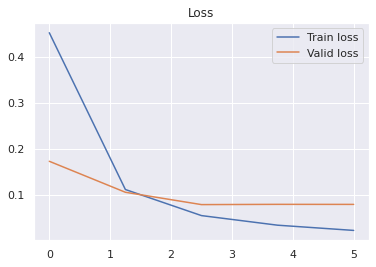

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_loss)
plt.plot(x,v_loss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

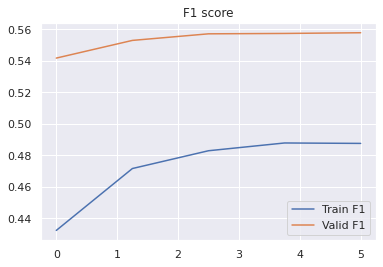

In [41]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_f1)
plt.plot(x,v_f1)
plt.title("F1 score")
plt.legend(["Train F1", "Valid F1"])

In [42]:
n = len(train_acc) - 2
n_tags = len(TAG.vocab)
for i in range(n_tags):   
    print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
           TAG.vocab.itos[i], train_acc[n][i][0],
           train_acc[n][i][1], train_acc[n][i][2]))  

Train Accuracy of <pad>:  0% ( 0/850)
Train Accuracy of     O: 99% (439/440)
Train Accuracy of B-LOC: 90% (19/21)
Train Accuracy of B-PER: 100% (20/20)
Train Accuracy of B-ORG: 92% (12/13)
Train Accuracy of I-PER: 100% (10/10)
Train Accuracy of I-ORG: 100% ( 6/ 6)
Train Accuracy of B-MISC: 80% ( 8/10)
Train Accuracy of I-LOC: 75% ( 3/ 4)
Train Accuracy of I-MISC: 50% ( 1/ 2)


In [43]:
n = len(valid_acc) - 2
for i in range(n_tags):
    print('Valid Accuracy of %5s: %2d%% (%2d/%2d)' % (
           TAG.vocab.itos[i], valid_acc[n][i][0],
           valid_acc[n][i][1], valid_acc[n][i][2]))
  

Valid Accuracy of <pad>:  0% ( 0/748)
Valid Accuracy of     O: 99% (606/607)
Valid Accuracy of B-LOC: 92% (13/14)
Valid Accuracy of B-PER: 33% (10/30)
Valid Accuracy of B-ORG: 60% ( 3/ 5)
Valid Accuracy of I-PER: 61% ( 8/13)
Valid Accuracy of I-ORG: 33% ( 1/ 3)
Valid Accuracy of B-MISC: 40% ( 4/10)
Valid Accuracy of I-LOC: 100% ( 1/ 1)
Valid Accuracy of I-MISC: 22% ( 2/ 9)


In [44]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc, test_f1 = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Loss: 0.140 |  Test F1 score: 54.87%


In [45]:
n = len(test_acc) - 2
n_tags = len(TAG.vocab)
for i in range(n_tags):   
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
           TAG.vocab.itos[i], test_acc[n][i][0],
           test_acc[n][i][1], test_acc[n][i][2]))


Test Accuracy of <pad>:  0% ( 0/1096)
Test Accuracy of     O: 99% (292/293)
Test Accuracy of B-LOC: 100% ( 5/ 5)
Test Accuracy of B-PER: 85% ( 6/ 7)
Test Accuracy of B-ORG: 100% (22/22)
Test Accuracy of I-PER: 100% ( 2/ 2)
Test Accuracy of I-ORG: 100% ( 9/ 9)
Test Accuracy of B-MISC: 50% ( 2/ 4)
Test Accuracy of I-LOC:  0% ( 0/ 2)
Test Accuracy of I-MISC: 100% ( 0/ 0)


On remarque que l'accuracy est n'est pas beaucoup meilleure que précédemment.

In [46]:
def tag_sentence(model, device, sentence, text_field, tag_field, char_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    max_word_len = max([len(token) for token in tokens])
    numericalized_chars = []
    char_pad_id = char_field.vocab.stoi[CHAR.pad_token] 
    for token in tokens:
        numericalized_chars.append(
                [char_field.vocab.stoi[char] for char in token]
                + [char_pad_id for _ in range(max_word_len - len(token))]
                )
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]

    unk_idx = text_field.vocab.stoi[text_field.unk_token]
    
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)
    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
    char_tensor = torch.as_tensor(numericalized_chars)
    char_tensor = char_tensor.unsqueeze(0).to(device) 
    
    predictions = model(token_tensor, char_tensor)
    
    top_predictions = predictions.argmax(-1)
    
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    
    return tokens, predicted_tags, unks

In [47]:
example_index = 39

sentence = vars(test_data.examples[example_index])['text']
actual_tags = vars(test_data.examples[example_index])['tag']

print(sentence)
print(actual_tags)

['two', 'goals', 'in', 'the', 'last', 'six', 'minutes', 'gave', 'holders', 'japan', 'an', 'uninspiring', '2-1', 'asian', 'cup', 'victory', 'over', 'syria', 'on', 'friday', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O']


In [48]:
tokens, pred_tags, unks = tag_sentence(model, 
                                       device, 
                                       sentence, 
                                       TEXT, 
                                       TAG,
                               
                                       CHAR)

print(pred_tags)
print(actual_tags)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O']


In [49]:
print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

O		O		✔		two
O		O		✔		goals
O		O		✔		in
O		O		✔		the
O		O		✔		last
O		O		✔		six
O		O		✔		minutes
O		O		✔		gave
O		O		✔		holders
B-LOC		B-LOC		✔		japan
O		O		✔		an
O		O		✔		uninspiring
O		O		✔		2-1
B-MISC		B-MISC		✔		asian
O		I-MISC		✘		cup
O		O		✔		victory
O		O		✔		over
B-LOC		B-LOC		✔		syria
O		O		✔		on
O		O		✔		friday
O		O		✔		.


In [50]:
sentence = 'The will deliver a speech about the conflict in North Korea tomorrow in New York with my friend Mary Kate.'

tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence, 
                                  TEXT, 
                                  TAG,
                                  CHAR)

print(unks)

[]


In [51]:
print("Pred. Tag\tToken\n")


for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")

Pred. Tag	Token

O		the
O		will
O		deliver
O		a
O		speech
O		about
O		the
O		conflict
O		in
O		north
B-LOC		korea
O		tomorrow
O		in
O		new
O		york
O		with
O		my
O		friend
O		mary
O		kate
O		.


On remarque que ce modèle ne donne pas de bons résultats.

## Référence : 

 - [Step-by-step NER Model for Bahasa Indonesia with PyTorch and Torchtext](https://medium.com/@yoseflaw/step-by-step-ner-model-for-bahasa-indonesia-with-pytorch-and-torchtext-6f94fca08406)